<a href="https://colab.research.google.com/github/ElenJ/NLP_demo/blob/main/NLPwTranformer_Ch2_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer # automatically retrieves model's configuration, weights, vocab
from transformers import AutoModel # to load weights from pretrained model
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
emotions = load_dataset("emotion")
emotions

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
# load train data
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [4]:
# convert emotions to pandas df
emotions.set_format(type="pandas")
df = emotions["train"][:]

def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


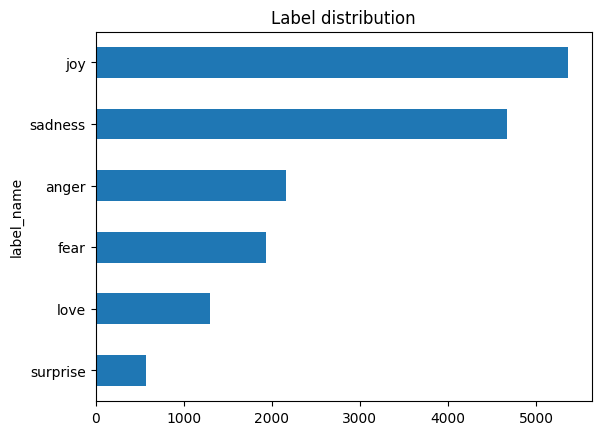

In [5]:
# look at label distribution
df["label_name"].value_counts(ascending=True).plot.barh(title="Label distribution")
plt.show()

The dataset is imbalanced and actually requires balancing of the classes to train a proper classifyer. TODO for later.

In [6]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


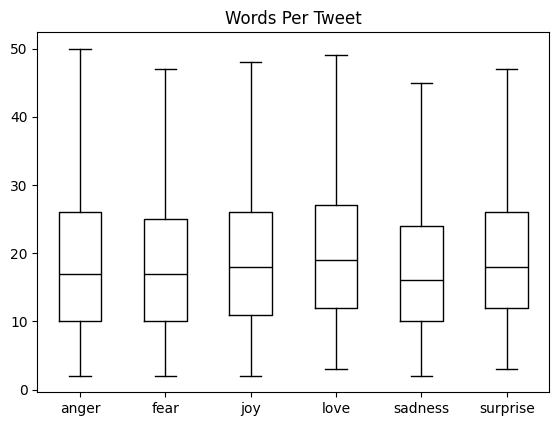

In [7]:
# look at the length of the texts, as this impacts selection of transformer, which has a certain maximum content size
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

The average tweet length of ~15 words is below the maximum content size of transformer models. We can go on, not fearing the need to truncate text and lose information.

In [8]:
emotions.reset_format() # reset format, don't need to have it as pandas anymore

# Tokenization

In [10]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer.model_max_length

512

In [11]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)
print(tokenize(emotions["train"][:2])) # demo for one

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [13]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Training a text classifyer

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [17]:
# dummy example
text ="this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"input tensor shape: {inputs['input_ids'].size()}")
#torch.Size([1, 6]) --> [batch size, tokens]

input tensor shape: torch.Size([1, 6])


In [18]:
# pass the input on same device
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad(): # disable automatic calculations of the gradient, reduces memory footprint of the gradient
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [19]:
outputs.last_hidden_state.size()
# [batch, tockens, hidden_dim], a 768-dim vector is returned for each of 6 input tokens.
# For classification, it is common practice to use the hidden state associated with the [CLS] token as input feature
# [CLS] is at the start of each sequence


torch.Size([1, 6, 768])

In [23]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [24]:
# retrieve last hidden state for my emotions dataset
def extract_hidden_states(batch):
  # Place model inputs on device
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  # extract last hidden state
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()} # map method requires teh function to return a python or numpy object when using batched inputs

In [25]:
# as the model expects tensors as input, need to convert input_ids and attention_mask to "torch" format
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# now we can extract hidden states:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True) # default batch size 1000 used

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [26]:
# function has added hidden_state column to emotions
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [28]:
# now we can train the classifyer based on the last hidden state
X_train = np.array(emotions_hidden["train"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, y_train.shape

((16000, 768), (16000,))

In [29]:
# recheck the input, by visualizing it
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
# scale features
X_scaled = MinMaxScaler().fit_transform(X_train)
# reduce dimensionality
mapper = UMAP(n_components=2, metric = "cosine").fit(X_scaled)
# cerate a dataFRame of 2D embeddings
db_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
db_emb["label"] = y_train
db_emb.head()

,X,Y,label
0,4.474658,3.067086,0
1,-2.972801,3.806463,0
2,5.487742,6.479013,3
3,-2.328321,5.888206,2
4,-3.236395,5.609839,3


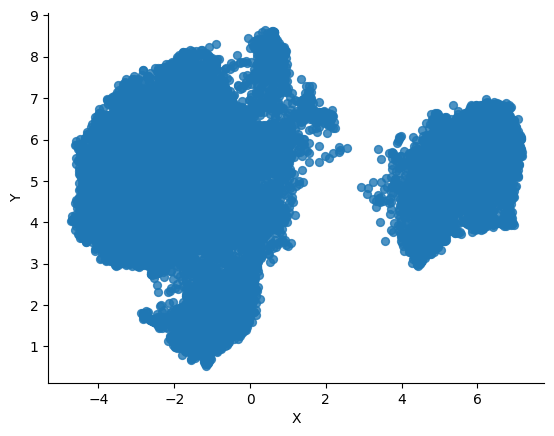

In [30]:
# @title X vs Y

from matplotlib import pyplot as plt
db_emb.plot(kind='scatter', x='X', y='Y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

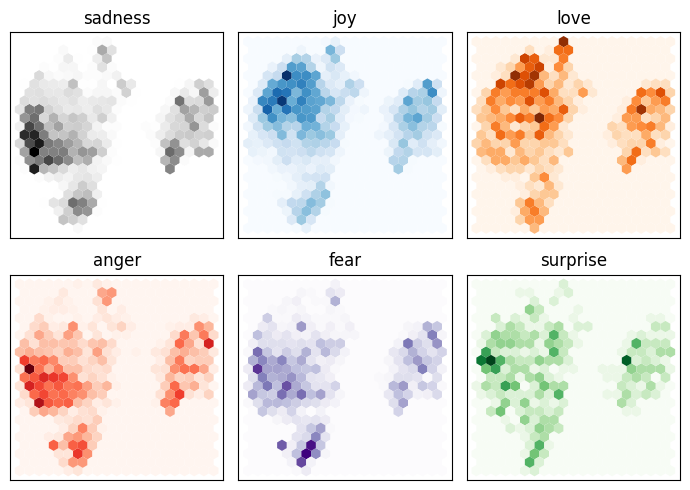

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
emotions_labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(emotions_labels, cmaps)):
  db_emb_filtered = db_emb.query(f"label == {i}")
  axes[i].hexbin(db_emb_filtered["X"], db_emb_filtered["Y"], cmap = cmap, gridsize = 20, linewidths = (0,))
  axes[i].set_title(label)
  axes[i].set_xticks([])
  axes[i].set_yticks([])
plt.tight_layout()
plt.show()

In [33]:
# training model
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [35]:
# compare this to a baseline classifyer
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

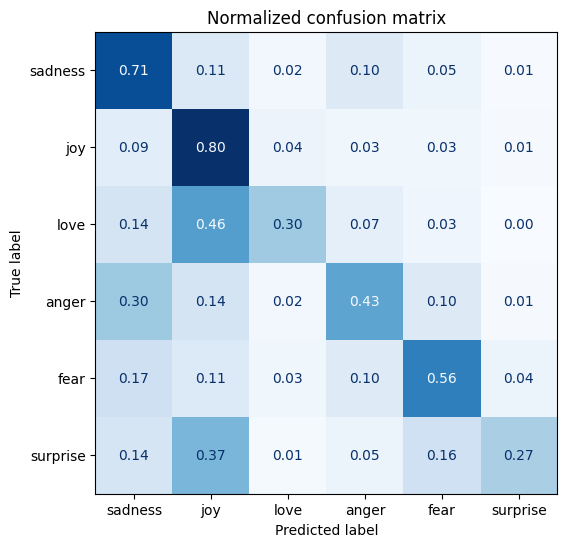

In [38]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, emotions["train"].features["label"].names)

## Fine-Tuning